Importing the necessary libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from copy import deepcopy
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.pyplot import figure as fig

Install validclust for calculating Dunn's Index

In [ ]:
!pip install validclust

Import the Dunns function to calucalate the Dunns Index

In [ ]:
from validclust import dunn

Loading the cifar dataset

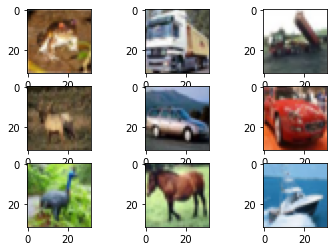

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#print the initial dataset
for index in range(9):
	plt.subplot(330 + 1 + index)
	plt.imshow(x_train[index])
plt.show()

# **Part 1: Implementing K-Means Clustering**

coverting the image to a grayscale

In [ ]:
XTrain = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
XTest = np.array([cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) for image in x_test])
print(XTrain.shape)
print(XTest.shape)

(10000, 32, 32)
(10000, 32, 32)


Normalize the data

In [ ]:
#function for normalization
def normalize(XTrain, XTest):
	trainNorm = XTrain.astype('float32')
	testNorm = XTest.astype('float32')
	trainNorm /= 255.0
	testNorm /= 255.0
	return trainNorm, testNorm

#Normalize the data
XTrain, XTest = normalize(XTrain, XTest)

#Reshape the data
XTrain = XTrain.reshape(-1,1024)
XTest = XTest.reshape(-1,1024)

#checking the shape
print(XTrain.shape)
print(XTest.shape)

(10000, 1024)
(10000, 1024)


**Algorithm to perform K means Clustering**

1.   Randomly, choose k examples as initial clusters
2.   while True:
1.   create k clusters by assigning each example to the closest centroid
2.        compute k new centroids by averaging examples in each cluster
1.          if difference between previous centroid and current centroid is 0:
2.              break          


In [ ]:
#Initialize K value
K = 10

#Function to Initialize Random Centroids
def initializeRandomCentroids(data, numFeatures):
    #Average of the given data
    mean = np.mean(data, axis = 0)
    #Standard Deviation of the given data
    standardDeviation = np.std(data, axis = 0)
    return np.random.randn(K,numFeatures)*standardDeviation + mean


#Function to Calculate K-Means Clustering
def kmeans(data):
    numInstances = data.shape[0]
    numFeatures = np.prod([data.shape[i] for i in range(len(data.shape)) if data.shape[i] != numInstances])
    featureShape = tuple(data.shape[i] for i in range(len(data.shape)) if data.shape[i] != numInstances)

    #Initialize centroidArray
    centroids = initializeRandomCentroids(data, numFeatures)

    #To print the Iteration numbers
    iteration = 0
    #To store previous calculated centroids 
    previousCentroids = np.zeros(centroids.shape) 
    #To store the current centroids 
    currentCentroids = deepcopy(centroids) 
    #To store the difference between old and new centroids
    difference = np.linalg.norm(currentCentroids - previousCentroids)
    #To store calculated distance between all points and the current centroids.
    distances = np.zeros((numInstances,K))
    
    clusters = np.zeros(numInstances)
   
    #Iterates the loop continously and breaks down when the previous centroid is equal to the current centroid or iterations crossed 300
    while True:
        #Calculate the distance to every centroid
        for i in range(K):
            distances[:,i] = np.linalg.norm(data - currentCentroids[i], axis=1)

        #Assign all the training data to nearest centeriod
        clusters = np.argmin(distances, axis = 1)
        #Copy the current values centroid to previous centroid
        previousCentroids = deepcopy(currentCentroids)
        #Calculate Average for every cluster and update the centeriod
        for i in range(K):
            currentCentroids[i] = np.mean(data[clusters == i], axis=0)
        #Calculate the eucledian distance difference between the previous centroids and the current centroids to break the loop when both are same 
        difference = np.linalg.norm(currentCentroids - previousCentroids)
        #printing the Iterations and Difference between old and new centroids
        iteration += 1
        print()
        print()
        print("********************      Iteration: ",iteration,"      ********************")
        print("Difference between old and new centroids are ", difference)
        #Break the loop if we get the same centroids or iterations crossed 300
        if(difference == 0.0 or iteration > 300):
           break
             
    centroids = currentCentroids.reshape(10,1024)

    return centroids 

Call the Kmeans function

In [ ]:
centroids = kmeans(XTrain)



********************      Iteration:  1       ********************
Difference between old and new centroids are  26.5014912386206


********************      Iteration:  2       ********************
Difference between old and new centroids are  4.730720379962293


********************      Iteration:  3       ********************
Difference between old and new centroids are  1.9471779806398992


********************      Iteration:  4       ********************
Difference between old and new centroids are  1.2006877588027804


********************      Iteration:  5       ********************
Difference between old and new centroids are  0.9962493543560076


********************      Iteration:  6       ********************
Difference between old and new centroids are  0.8711939955686372


********************      Iteration:  7       ********************
Difference between old and new centroids are  0.7398080191895002


********************      Iteration:  8       *****************

Calculate our final Results

In [ ]:
#To calculate the Euclidean Distance
distanceArray = cdist(XTrain, centroids ,'euclidean')
#Assign the points to the final centroid 
pointArray = np.array([np.argmin(i) for i in distanceArray])

#Calculate the Sihoutte Score
print('Average Silhouette Score: ',silhouette_score(XTrain,pointArray))
#Calculate the Dunn's Index
print('Dunn Index: ',dunn(pairwise_distances(XTrain),pointArray))

Average Silhouette Score:  0.056311768
Dunn Index:  0.09360166


plotting the final clusters data

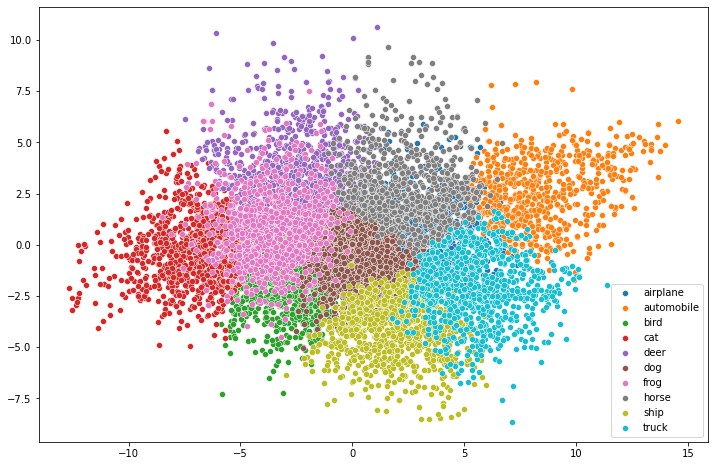

In [ ]:
fig(figsize=(12, 8))
colors=['green','yellow','red','black','gray','maroon','purple','fushsia','blue','navy']
label=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
data = PCA(1024).fit_transform(XTrain)
for i in range(10):
  sns.scatterplot(data=data, x=data[pointArray==i][:,0],y=data[pointArray==i][:,1])

plt.legend(label,loc='lower right')
plt.show()

# **Part 2: Implementing Auto-Encoder**

Importing necessary Modules

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from tensorflow.keras.optimizers import Adam 
from sklearn.cluster import KMeans

Normalize input Data

In [ ]:
x_train, x_test = normalize(x_train, x_test)

Building the Model

In [ ]:
image = Input(shape=(32, 32, 3))

#Encoder
encode = Conv2D(64, (3, 3), padding='same')(image)
encode = Activation('relu')(BatchNormalization()(encode))
encode = MaxPooling2D((2, 2), padding='same')(encode)

encode = Conv2D(32, (3, 3), padding='same')(encode)
encode = Activation('relu')(BatchNormalization()(encode))
encode = MaxPooling2D((2, 2), padding='same')(encode)

encode = Conv2D(16, (3, 3), padding='same')(encode)
encode = Activation('relu')(BatchNormalization()(encode))
encoded = MaxPooling2D((2, 2), padding='same')(encode)

#Decoder
decode = Conv2D(16, (3, 3), padding='same')(encoded)
decode = Activation('relu')(BatchNormalization()(decode))
decode = UpSampling2D((2, 2))(decode)

decode = Conv2D(32, (3, 3), padding='same')(decode) 
decode = Activation('relu')(BatchNormalization()(decode))
decode = UpSampling2D((2, 2))(decode)

decode = Conv2D(64, (3, 3), padding='same')(decode)
decode = Activation('relu')(BatchNormalization()(decode))
decode = UpSampling2D((2, 2))(decode)

decode = Conv2D(3, (3, 3), padding='same')(decode)
decoded = Activation('sigmoid')(BatchNormalization()(decode))

model = Model(image, decoded)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


Now, Training the Decoded Model

In [ ]:
model.fit(x_train, x_train, batch_size=256, epochs=50, verbose=1, shuffle=True)

Epoch 1/50
196/196 [==============================] - 16s 65ms/step - loss: 0.0207 - accuracy: 0.5639
Epoch 2/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0137 - accuracy: 0.6535
Epoch 3/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0121 - accuracy: 0.6878
Epoch 4/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0110 - accuracy: 0.7061
Epoch 5/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0103 - accuracy: 0.7169
Epoch 6/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0097 - accuracy: 0.7240
Epoch 7/50
196/196 [==============================] - 12s 62ms/step - loss: 0.0092 - accuracy: 0.7305
Epoch 8/50
196/196 [==============================] - 12s 63ms/step - loss: 0.0088 - accuracy: 0.7358
Epoch 9/50
196/196 [==============================] - 12s 62ms/step - loss: 0.0085 - accuracy: 0.7382
Epoch 10/50
196/196 [==============================] - 12s 62ms/step - loss: 0.008

Now, Applying K means to the encoded images 

In [ ]:
#Build the encoded Model
encodedmodel = Model(image, encoded)
encodedmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
encodedImages = encodedmodel.predict(x_train)
encodedImages = encodedImages.reshape(-1,1024)
#Apply K means to the encoded Images
kmeans = KMeans(K)
kmeans.fit(encodedImages)
clusterPoints = kmeans.predict(encodedImages)

Calculate our final results( Silhouette, Dunn's )

In [ ]:
#Calculate the Sihoutte Score
print('Average Silhouette Score: ',silhouette_score(encodedImages,clusterPoints))
#Calculate the Dunn's Index
print('Dunn Index: ',dunn(pairwise_distances(encodedImages),clusterPoints))

Average Silhouette Score:  0.019351285
Dunn Index:  0.3701047


Now, Plotting the original data VS the image after the decode

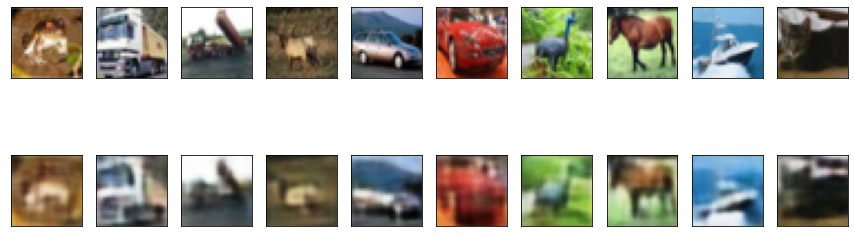

In [ ]:
def plotImage(image,graph):
    plt.imshow(image.reshape(32, 32, 3))
    graph.get_xaxis().set_visible(False)
    graph.get_yaxis().set_visible(False)

def plotOldandNewImages(actualImages, decodedImages):
    fig(figsize=(15, 5))
    n=10
    for i in range(n):
        # Actual Images
        graph = plt.subplot(2, n, i+1)
        plotImage(actualImages[i],graph)

        # Reconstrution Images after Decode
        graph = plt.subplot(2, n, i +1 + n)
        plotImage(decodedImages[i],graph)
        
    plt.show()

decodedImages = model.predict(x_train)
plotOldandNewImages(x_train, decodedImages)